In [3]:
import bisect
import math
import os
import random
import struct as st

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from itertools import compress
from numpy.random import RandomState

from sklearn import decomposition as dcmp

In [43]:
DBNOISE = 50 # dynamic range, used to establish noise floor
SPECT_SHAPE2D = (1528, 100) # 2D spectrogram shape (# freq. bins, # time bins)
N_SOUNDS = 49012 # total number of sounds in dataset

rng = RandomState(132) # arbitrary random state seed

var_explained_cutoff = 98 # target percent variance explained for PC space

In [5]:
#data_folder = '../../' # for Nate's MacBook Pro
data_folder = '/data/SoundData/' # for Chico

features_path = os.path.join(data_folder, 'acoustic_features_setA.h5')
labels_path = os.path.join(data_folder, 'label_names')
spectrograms_path = os.path.join(data_folder, 'sound_arrays.h5')
file_names_path = os.path.join(data_folder, 'spectrogram_file_names')

In [209]:
def plot_sound_features(featureVecs, n_figs = 10, plot_shape = (2, 5), f_low = 250, f_high = 10000, labels = None, 
                        subplot = False, noise_floor = True):
    ''' Plots spectrograms or spectrogram components (represented as an 2D array, where rows are feature vectors for each
    sound sample and columns are time/frequency features) as 2D representations in time and frequency space
    
    Note: assumes size of each component equals # frequency bins x # time bins in spectrogram dataset
    
    Parameters
    ----------
    feature_vectors: (numpy array, [# of vectors] x [# freq. bins x # time bins])
    n_figs: int, number of example figures
    f_low: int, lower frequency limit (y axis minimum)
    f_hight: int, upper frequency limit (y axis maximum)
    '''
    DBNOISE = 50 # dynamic range, used to establish noise floor
    DATABOUNDS = (0, 99, 0, 79952) # (t_min, t_max, f_min, f_max)
    SPECT_SHAPE2D = (1528, 100) # 2D spectrogram shape (# freq. bins, # time bins)
    
    WIDTH = .4
    HEIGHT = .8
    XMARGIN = .1
    YMARGIN = .125
    
    random.seed(1325)
    
    if subplot:
        sample_idxs = np.array(random.sample(range(featureVecs.shape[0]), np.prod(plot_shape))).reshape(plot_shape)
        
        plt.figure()
        
        for r in range(plot_shape[0]):
            for c in range(plot_shape[1]):
                idx = sample_idxs[r,c]
                soundSpect = featureVecs[idx,:].reshape(SPECT_SHAPE2D) # reshape vector to 2D
                
                # Set signal limits
                maxB = soundSpect.max()
                if noise_floor:
                    minB = maxB - DBNOISE
                    soundSpect[soundSpect < minB] = minB
                else:
                    minB = soundSpect.min()
                
                left = XMARGIN*(c+1) + WIDTH*c
                bottom = YMARGIN*(r+1) + HEIGHT*r
                
                plt.axes((left, bottom, WIDTH, HEIGHT))
                
                plt.imshow(soundSpect, extent = DATABOUNDS, aspect = 'auto', interpolation = 'nearest', 
                                origin = 'lower', cmap = 'binary', vmin = soundSpect.min(), vmax = maxB)
                plt.colorbar()
                
                plt.xlim(0,100)
                plt.ylim(f_low, f_high)
                
                if r == 0:
                    plt.xlabel('Time (ms)')
                else:
                    plt.xticks([])
                    
                if c == 0:
                    plt.ylabel('Frequency (Hz)')
                else:
                    plt.yticks([])
                
                if labels is not None:
                    plt.title(labels[idx])
                
                plt.show()
            
    else:
        sample_idxs = np.array(random.sample(range(featureVecs.shape[0]), n_figs))
        
        for idx in sample_idxs:
            plt.figure()
            plt.axes((XMARGIN, YMARGIN, WIDTH, HEIGHT))

            soundSpect = featureVecs[idx,:].reshape(SPECT_SHAPE2D) # reshape vector to 2D

            # Set signal limits
            maxB = soundSpect.max()
            minB = soundSpect.min()
            minB = maxB - DBNOISE
            soundSpect[soundSpect < minB] = minB

            # Plot as spectrogram
            plt.imshow(soundSpect, extent = DATABOUNDS, aspect = 'auto', interpolation = 'nearest', origin = 'lower',
                      cmap = 'binary', vmin = soundSpect.min(), vmax = maxB)
            plt.colorbar()

            plt.ylim(f_low, f_high)
            plt.xlim(0, 100)
            plt.xlabel('Time (ms)')
            plt.ylabel('Frequency (Hz)')

            if labels is not None:
                plt.title(labels[idx])

            plt.show()

# Subsample Spectrogram Dataset

In [7]:
# Filter out spectrograms which have inappropriate number of labels or contain inf/nan values
with h5py.File(features_path) as features:
    label_idxs = np.where(np.sum(np.array(features['labels']), axis=1) == 1)[0]

with h5py.File(spectrograms_path) as spectrograms:
    sound_idxs = np.where(np.all(np.isfinite(np.array(spectrograms['spectograms'])), axis = (1,2)))[0]

valid_idxs = np.intersect1d(label_idxs, sound_idxs, assume_unique = True)

In [8]:
# Compile dict with indices of spectrograms organized by sound category
category_idxs = {}
with h5py.File(features_path) as features:
    labels = features['labels']
    
    for label_idx in range(19):
        # get list indices for which the given sound label/category applies (is stored as True)
        category_idxs[label_idx] = np.intersect1d(valid_idxs,
                                                  list(compress(range(N_SOUNDS), labels[:,label_idx])),
                                                  assume_unique = True)

In [9]:
# Get list of sound category names (strings)
category_names = []
with open(labels_path) as names:
    for line in names:
        category_names.append(line[:-1].strip())

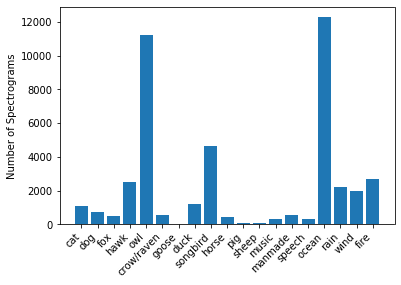

cat:  1103
dog:  758
fox:  480
hawk:  2477
owl:  11192
crow/raven:  580
goose:  0
duck:  1179
songbird:  4618
horse:  406
pig:  79
sheep:  94
music:  304
manmade:  532
speech:  304
ocean:  12268
rain:  2220
wind:  2002
fire:  2679


In [10]:
# Visualization of how many sounds are in each category

n_per_category = [len(idxs) for idxs in category_idxs.values()] # number of sounds per category

%matplotlib inline
plt.bar(np.arange(19), n_per_category, tick_label=category_names)
plt.xticks(ha = 'right', rotation = 45)
plt.ylabel('Number of Spectrograms')
plt.show()

for cat in range(19):
    print('%s:  %i' % (category_names[cat], len(category_idxs[cat])))

In [236]:
# Randomly (sub)sample up to 1000 sound samples from each category

max_samples = 1000 # maximum number of samples per category
train_prop = .8 # proportion of samples that are in training set (rest are in test set)
random.seed(13) # set random number generator at arbitrary seed

train_idxs = []
test_idxs = []
for idxs in category_idxs.values():
    if len(idxs) > max_samples:
        n_samples = max_samples
    else:
        n_samples = len(idxs)
    
    samples = random.sample(list(idxs), n_samples)
    train_idxs += samples[:round(train_prop*n_samples)]
    test_idxs += samples[round(train_prop*n_samples):]

train_idxs.sort()
test_idxs.sort()

In [237]:
with h5py.File(spectrograms_path) as spectrograms:
    train_set = np.array(spectrograms['spectograms'][train_idxs,:,:]) # training set of spectrograms

# reshape to 2d array (rows = sounds, cols = features)
train_set = train_set.reshape((len(train_idxs), np.prod(SPECT_SHAPE2D)))

# zero-average each feature across sounds in training set
features_avg = np.nanmean(train_set,0)
train_set -= features_avg

In [238]:
train_labels = []
test_labels = []

with open(file_names_path) as file_names:
    i = 0
    for line in file_names:
        if i in train_idxs:
            train_labels.append(line.split('/')[-1].split('.')[0])
        elif i in test_idxs:
            test_labels.append(line.split('/')[-1].split('.')[0])
        
        i += 1

# Perform PCA on Spectrograms

In [239]:
# Perfrom PCA with just enough PCs to hit the target variance explained
pca_model = dcmp.PCA(whiten = True, random_state = rng)
train_set_pc = pca_model.fit_transform(train_set) # PC representation of data

In [226]:
train_set_pc.shape

(243, 141)

In [242]:
%matplotlib qt
plt.figure()
plt.plot(pca_model.explained_variance_)
plt.yscale('log')

In [206]:
pc_reconstruction = pca_model.inverse_transform(train_set_pc)

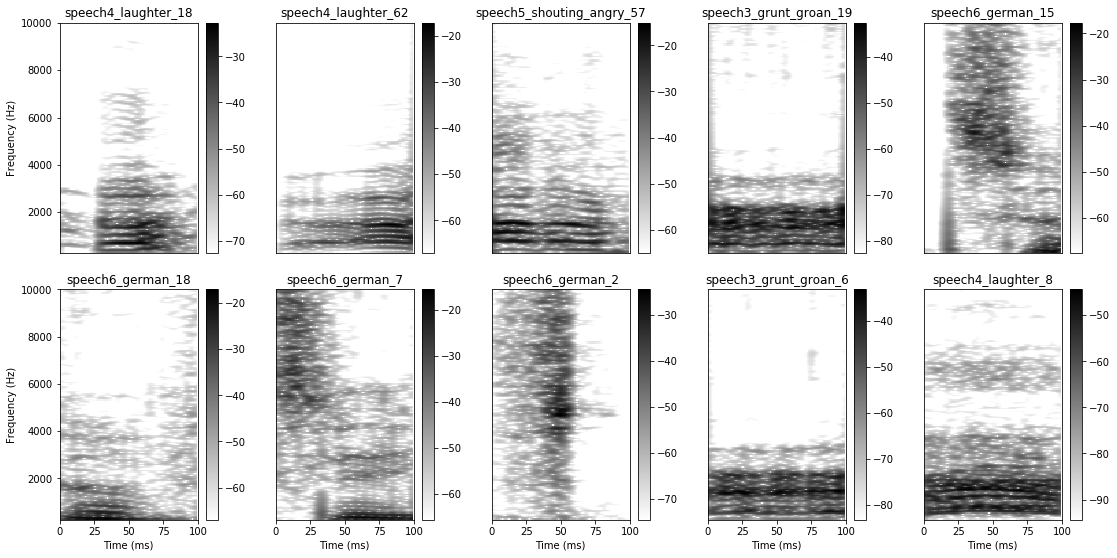

In [228]:
plot_sound_features(train_set+features_avg, labels = train_labels, plot_shape = (2,5), subplot = True)

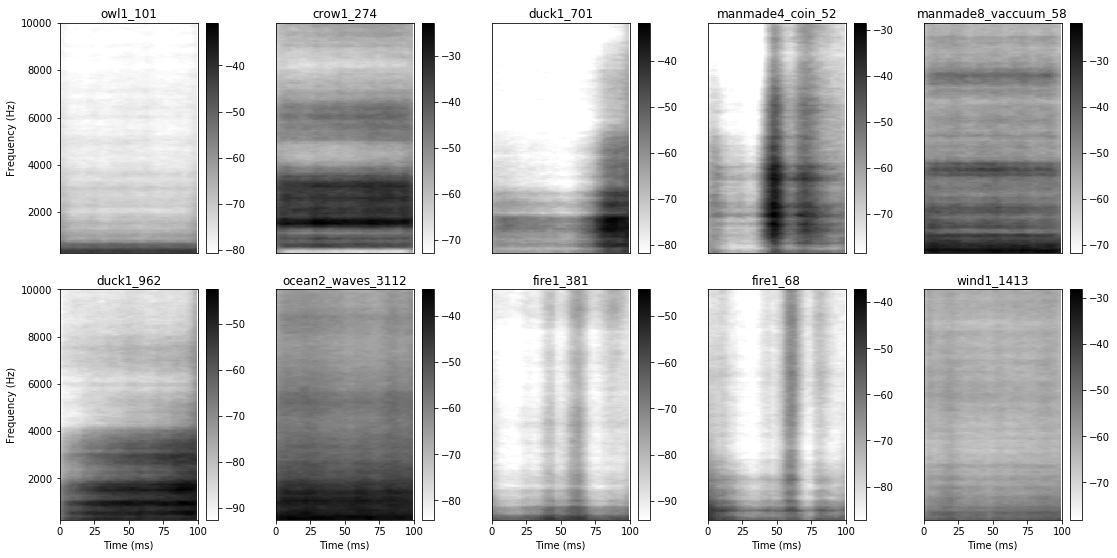

In [212]:
plot_sound_features(pc_reconstruction+features_avg, labels = train_labels, plot_shape = (2,5), subplot = True)

# Train Sparse Coding Model

In [229]:
dict_size = n_pcs_cutoff*2 # number of components in dictionary
alpha = .5 # sparseness parameter
n_iter = 500 # number of training iterations
batch_size = 50

# Initialize sparse coding model -- CONSIDER SETTNG CUSTOM BATCH SIZE
sparse_model = dcmp.MiniBatchDictionaryLearning(n_components = dict_size,
                                               alpha = alpha,
                                               fit_algorithm = 'cd',
                                               n_iter = n_iter,
                                               random_state = rng,
                                               batch_size = batch_size)

sparse_model.fit(train_set_pc) # Train model on training set

MiniBatchDictionaryLearning(alpha=0.5, batch_size=50, dict_init=None,
                            fit_algorithm='cd', n_components=324, n_iter=500,
                            n_jobs=None, positive_code=False,
                            positive_dict=False,
                            random_state=RandomState(MT19937) at 0x7F3C950B38D0,
                            shuffle=True, split_sign=False,
                            transform_algorithm='omp', transform_alpha=None,
                            transform_n_nonzero_coefs=None, verbose=False)

In [230]:
components = pca_model.inverse_transform(sparse_model.components_) # get components in pixel space

# Evaluate Dictionary Quality

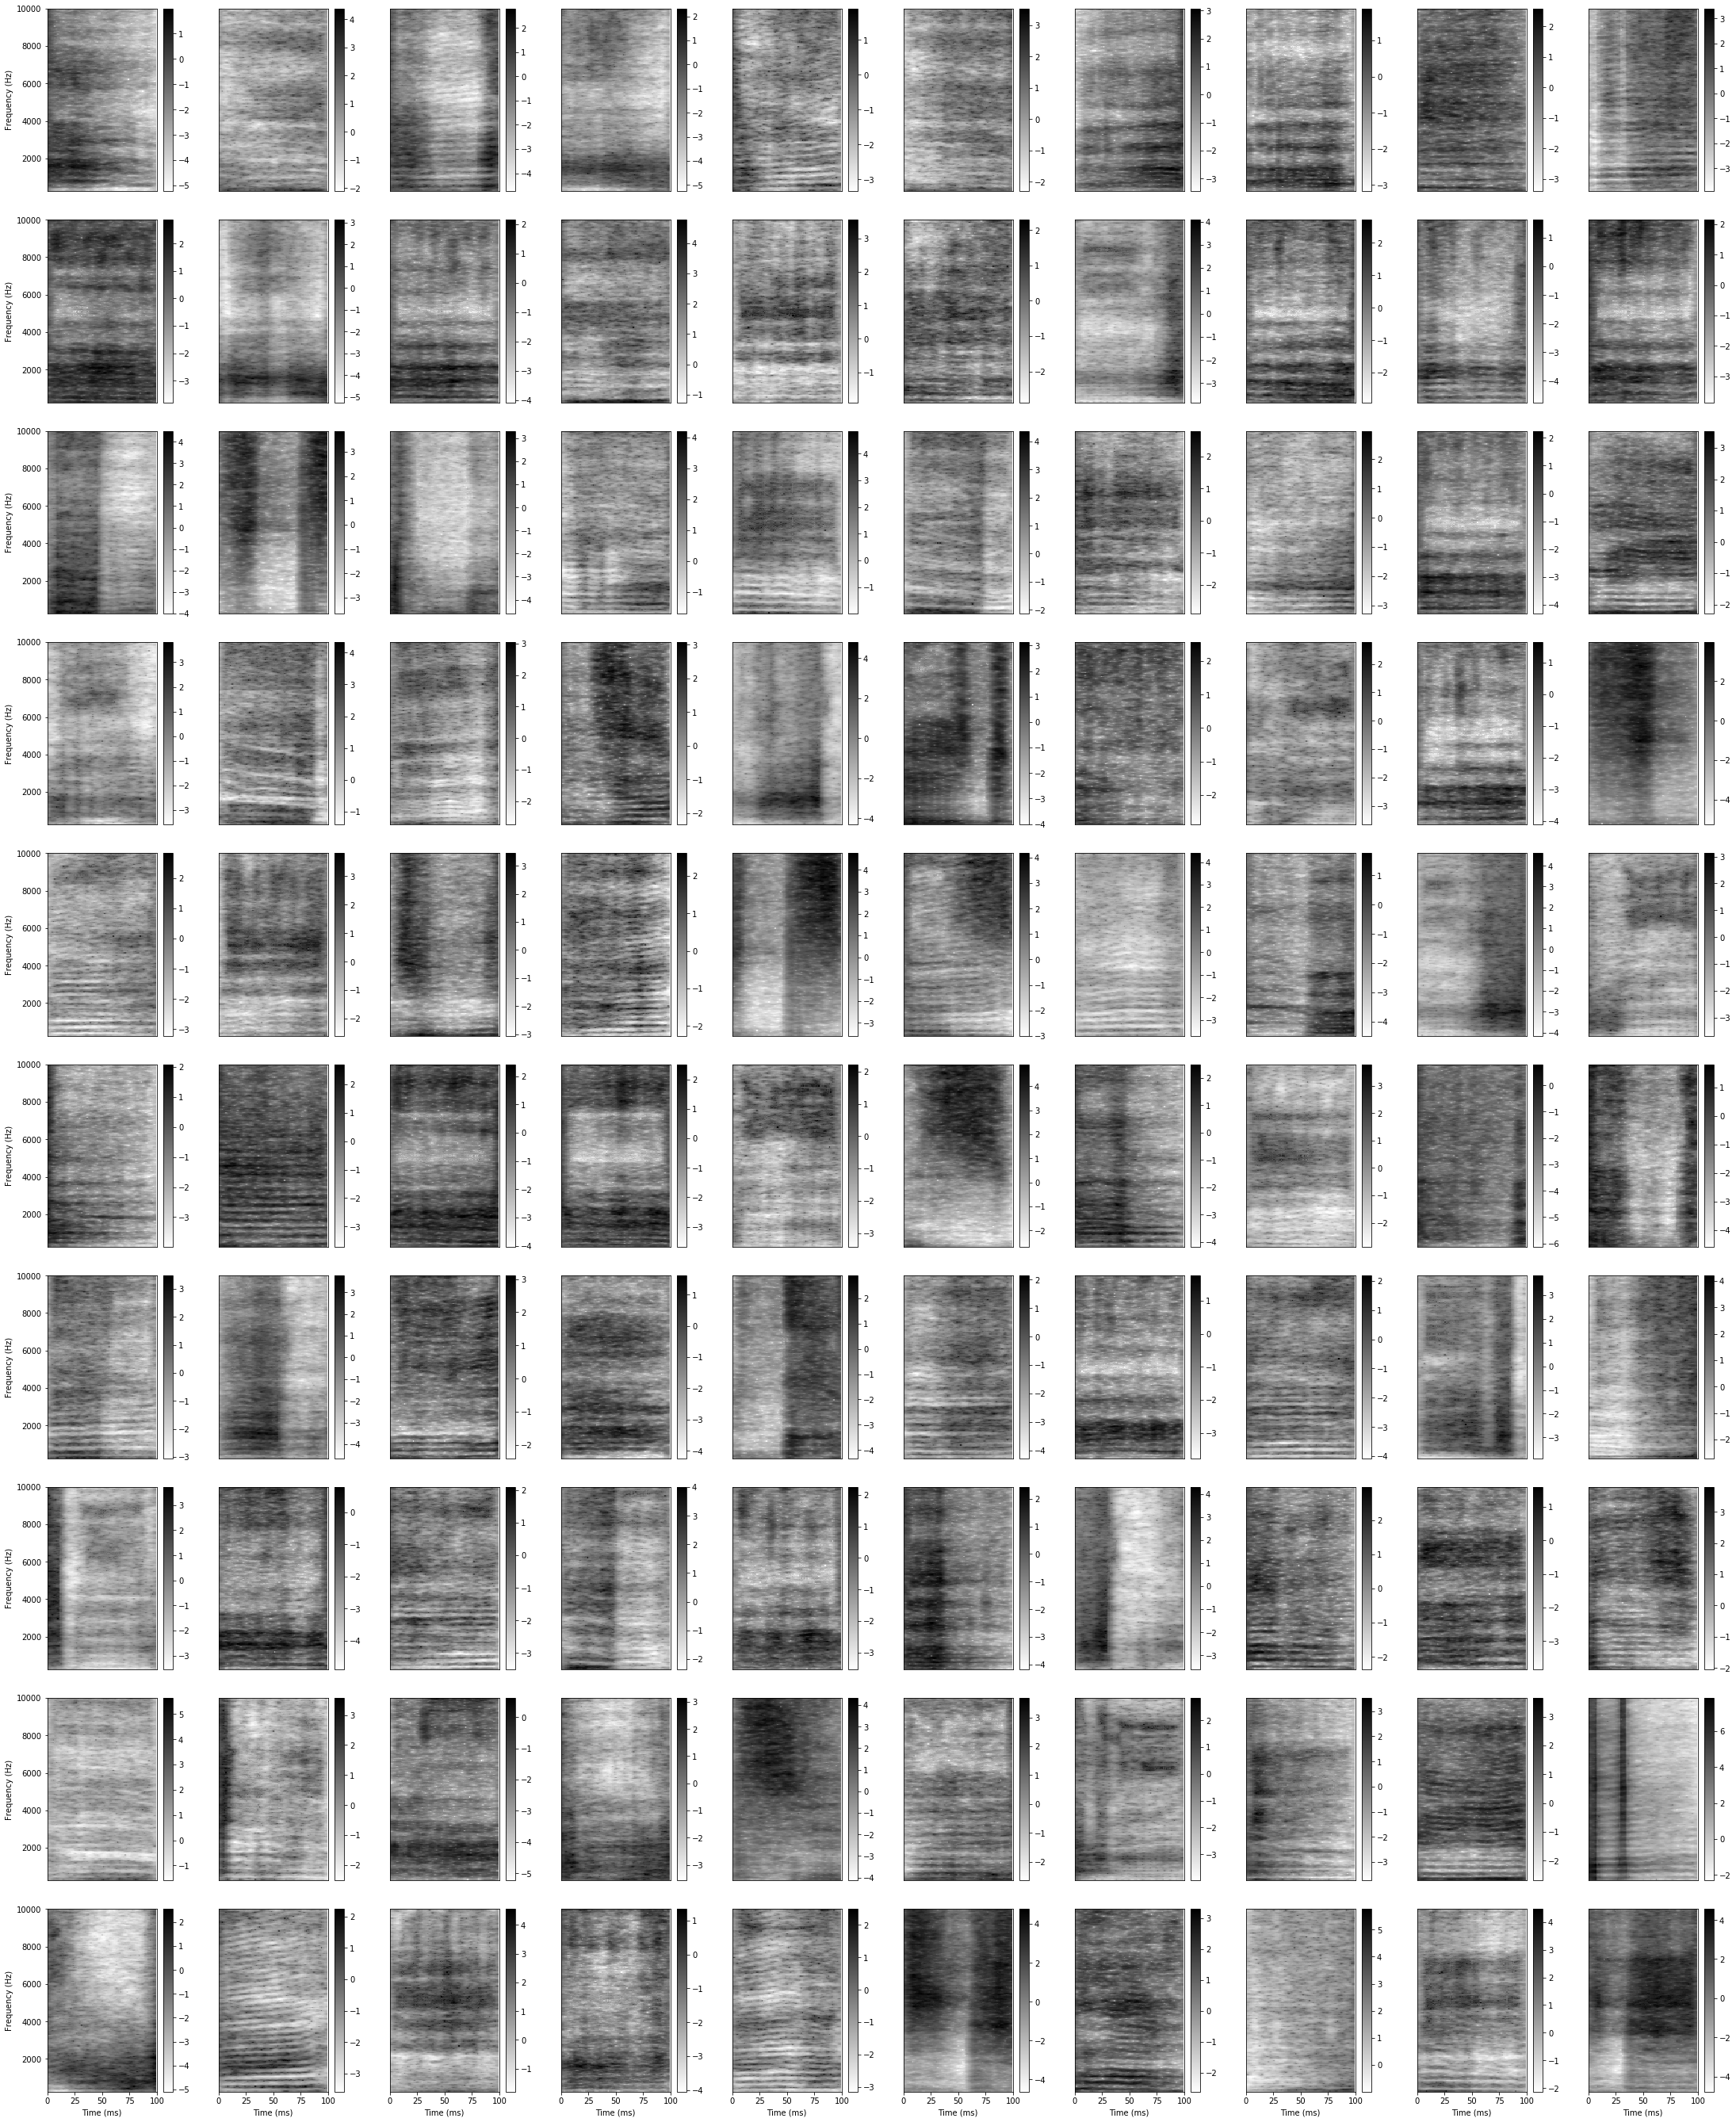

In [235]:
plot_sound_features(components, plot_shape = (10,10), subplot = True, noise_floor = True)